In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes, list_as_ascii, gen_added_strings
from nengo_learn_assoc_mem.paths import data_path
from nengo_learn_assoc_mem.learning_rules.fake_voja import FakeVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple
import os

c:\tools\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [2]:
n_items = 16
dimensions = 32
n_neurons = 500
dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [3]:
n_repeats = 1
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)

intercepts = nengo.dists.Uniform(0.1, 0.15).sample(n_neurons)

In [4]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [5]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [11]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [12]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [6]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## PES

In [7]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [33]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens.neurons, output, transform=np.zeros((dimensions, n_neurons)),
                                learning_rule_type=nengo.PES(1e-2))
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_err = nengo.Probe(pes_learn_control, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [36]:
learned_sim.data[p_err].shape

(25700, 32)

(-0.1, 0.1)

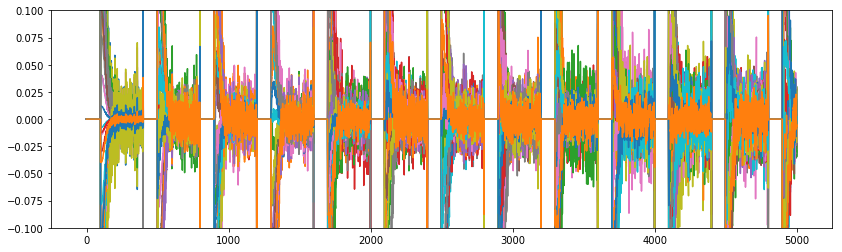

In [45]:
plt.figure(figsize=(14, 4))
plt.plot(learned_sim.data[p_err][:5000])
plt.ylim(-0.1, 0.1)

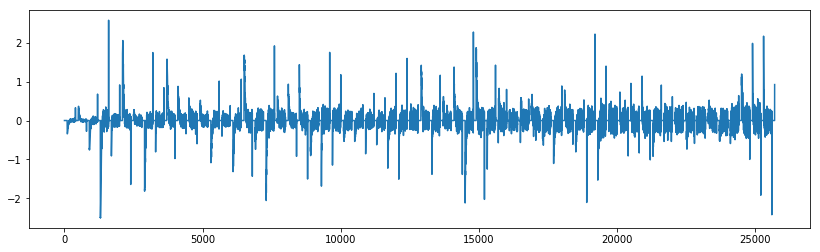

In [38]:
plt.figure(figsize=(14, 4))
plt.plot(np.sum(learned_sim.data[p_err], axis=1))

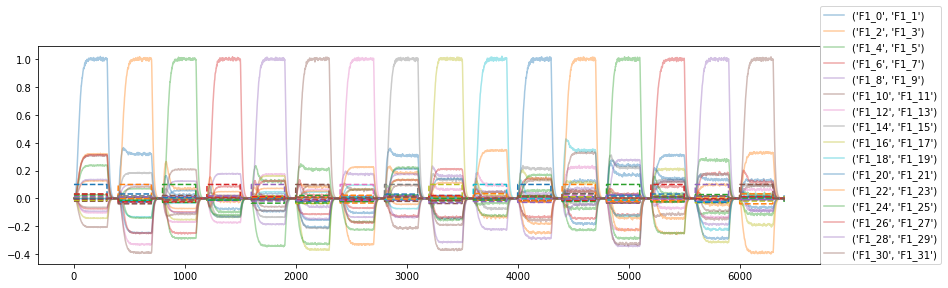

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

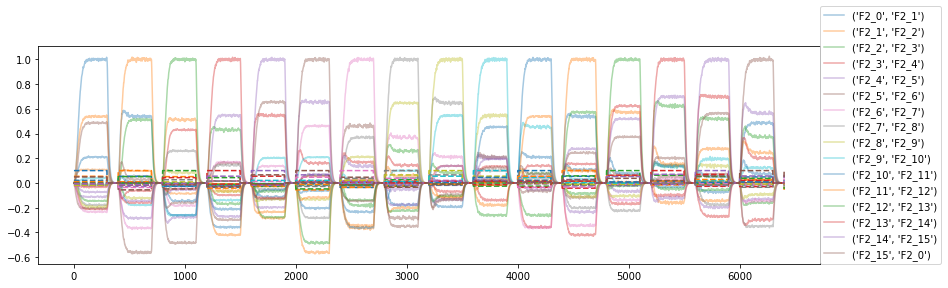

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [15]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 500)

# Test

In [18]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)
    #nengo.Connection(ens, output)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

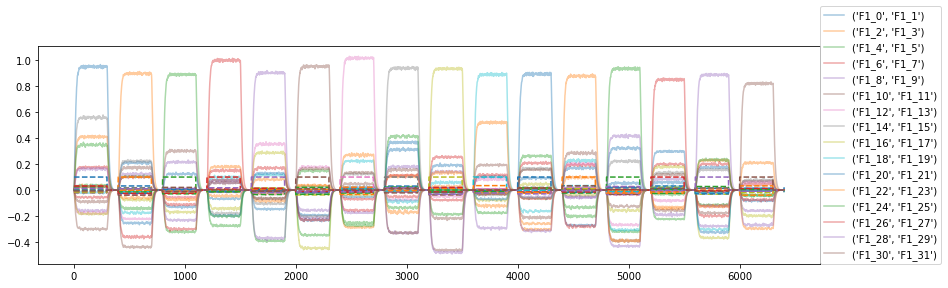

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

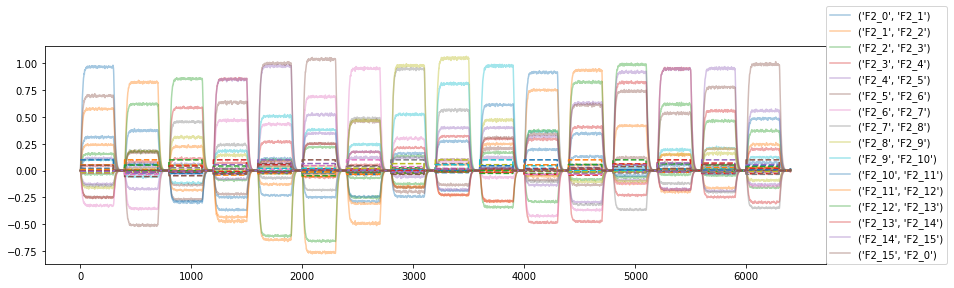

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

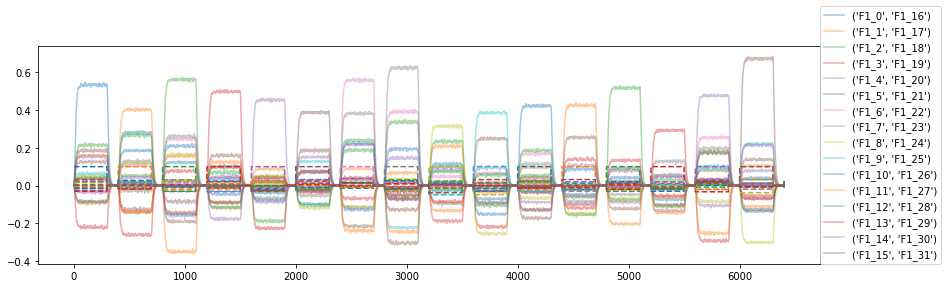

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [22]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [23]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [24]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [25]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[282.05953338 266.1296542  264.2305833  297.04370729 268.58879732
 283.42498623 302.4967065  278.83723145 278.04712407 263.98538163
 264.98245288 261.0591718  277.61550639 252.52159727 263.89585679
 243.97526389]
271.8058471502016


In [26]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [27]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 21 21 22 24 24 25 26 27 28 29 30 31]
[287.9814908  245.24124659 255.56475127 254.94858595 298.47890318
 310.18876904 283.74582886 292.12451616 312.87773232 291.40890097
 273.2117747  279.48375873 294.88405715 282.99827453 283.93722464
 294.95434119]
283.8768847560068


## Compare reaction times

In [28]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [29]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [30]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 257.2126602847271
fan2 267.7458654558833
foil1 132.51870541113965
foil2 180.55200516749161


In [31]:
conf_df = pd.DataFrame(confs)

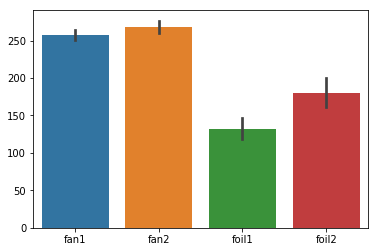

In [32]:
sns.barplot(data=conf_df)